# Gaussian Processes

[Gaussian Process for Dummies - Link](http://katbailey.github.io/post/gaussian-processes-for-dummies/) (probably adopted from Nando de Freitas code)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import scipy
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [2]:
# Create training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
noise = 0.2
ytrain = np.sin(Xtrain) # + np.random.normal(0, noise, size=(5,1))
n_t = len(Xtrain)

In [3]:
# "Test" data (what we want to estimate/interpolate)
n_s = 50
Xtest = np.linspace(-5, 5, n_s).reshape(-1,1)

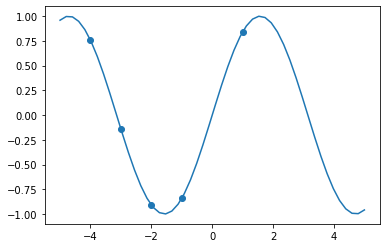

In [4]:
plt.scatter(Xtrain, ytrain)
plt.plot(Xtest, np.sin(Xtest))

### Kernel-First view

In [5]:
# Define the kernel function - squared exponential
def kernel(a, b, l=1, sig_var=1):
    '''Squared Exponential kernel = sig_var*exp(-0.5/l**2 * ||x - x'||^2)
    '''
    distance = sklearn.metrics.pairwise_distances(a,b)
    return sig_var*np.exp(-1/(2*l**2)*distance**2)

#### Prior

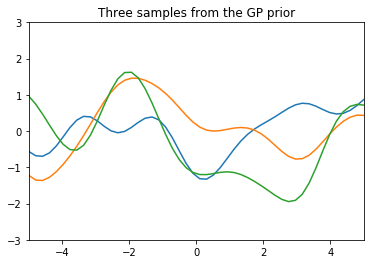

In [7]:
# draw 3 gaussians from this kernel
K_ss = kernel(Xtest, Xtest)

f_prior = np.random.multivariate_normal(mean=np.zeros(n_s), cov=K_ss, size=3).T

# Now let's plot the 3 sampled functions.
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP prior')
plt.show()

#### Posterior

In [8]:
# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain)
noise = 0  # sigma^2
K_inv = np.linalg.inv(K + noise*np.eye(n_t))
# and to our mutual
K_s = kernel(Xtrain, Xtest)
# compute mean
mu = K_s.T@K_inv@ytrain.squeeze()
# compute covariance matrix, and corresponding stdv (sqrt diagonal values)
cov = K_ss-K_s.T@K_inv@K_s
stdv = np.sqrt(np.diag(cov)).squeeze()

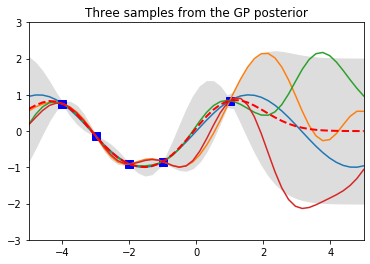

In [9]:
# Draw samples from the posterior at our test points. 
f_post = np.random.multivariate_normal(mean=mu, cov=cov, size=3).T

# plot
plt.plot(Xtest, np.sin(Xtest))
plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

For numerical reasons, since K is always Symmetric and usually Positive-Definite, Cholesky decomposition is better.

$$K = LL^T$$
$$Kx = y \Rightarrow LL^Tx = y \Rightarrow Lu=y , L^Tx = u$$ 

In [10]:
# Cholesky Decomposition (instead of inverting the K+sigma matrix)
L = np.linalg.cholesky(K + noise*np.eye(n_t))
alpha = np.linalg.solve(L.T, np.linalg.solve(L, ytrain))
mu = (K_s.T@alpha).squeeze()
v = np.linalg.solve(L, K_s)
cov =  K_ss - v.T@v

In [11]:
def GP(Xtrain, ytrain, Xtest, l=1, sig_var=1, noise_var=0):
    K_ss = kernel(Xtest, Xtest, l, sig_var)
    K = kernel(Xtrain, Xtrain, l, sig_var)
    L = np.linalg.cholesky(K + noise_var*np.eye(n_t))
    K_s = kernel(Xtrain, Xtest, l, sig_var)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, ytrain))
    mu = (K_s.T@alpha).squeeze()
    v = np.linalg.solve(L, K_s)
    cov =  K_ss - v.T@v
    stdv = np.sqrt(np.diag(cov)).squeeze()
    # plot
    plt.figure(figsize=(10,8))
    plt.plot(Xtrain, ytrain, 'bs', ms=8)
    plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
    plt.plot(Xtest, mu, 'r--', lw=2)
    plt.axis([-5, 5, -3, 3])
    plt.title('Three samples from the GP posterior')
    plt.show()

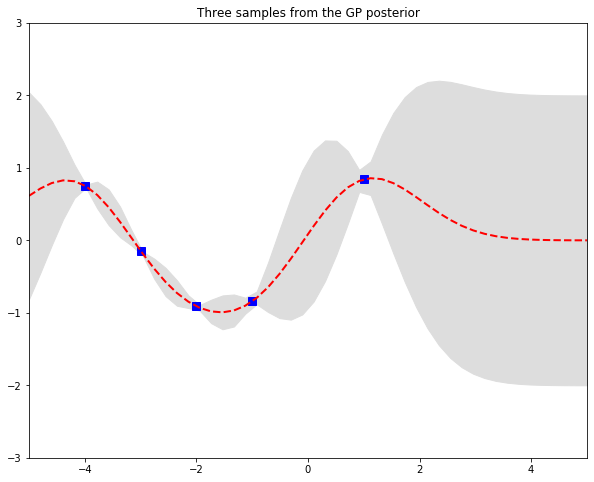

In [18]:
GP(Xtrain, ytrain, Xtest, 1, 1, 0)

### Prior view

Project data into a polynomial feature space, up to 5th degree:

$$x \to \phi(x)$$


In [19]:
# Let's try to interpolate with a 5-th degree polynomial some sin points
phi_test = np.column_stack((np.ones(n_s), Xtest, Xtest**2, Xtest**3, Xtest**4, Xtest**5)).T
phi_train = np.column_stack((np.ones(n_t), Xtrain, Xtrain**2, Xtrain**3, Xtrain**4, Xtrain**5)).T

# prior on the coefficients - N(0, Sigma_p)
# Assuming an identity covariance matrix for prior (Sigma_p = I)
# Sigma_p = np.eye(6)
t = np.random.normal(size=(6,6))
Sigma_p = t.T@t

In [25]:
sigma2_n = 0.00

In [26]:
K = phi_train.T@Sigma_p@phi_train
K_s = phi_test.T@Sigma_p@phi_train
K_ss = phi_test.T@Sigma_p@phi_test

In [27]:
a = K_s@np.linalg.inv(K + sigma2_n*np.eye(n_t))
mu = a@ytrain
mu = mu.squeeze()

In [28]:
cov = K_ss - a@K_s.T
cov = cov.squeeze() 
stdv = np.sqrt(np.diag(cov)).squeeze()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


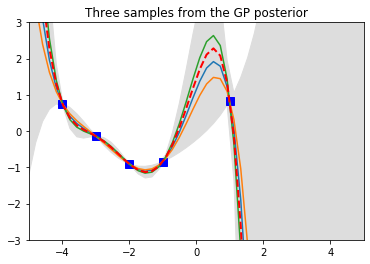

In [29]:
# Draw samples from the posterior at our test points. 
f_post = np.random.multivariate_normal(mean=mu, cov=cov, size=3).T

# plot
plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

# 2D example

In [30]:
# Test data
nx, ny = (50, 50)
x = np.linspace(-5, 5, nx)
y = np.linspace(-5, 5, ny)
xv, yv = np.meshgrid(x,y)
Xtest = np.column_stack([xv.ravel(),yv.ravel()])

In [31]:
# Noiseless training data
nx_tr, ny_tr = (20, 20)
x = np.linspace(-5, 5, nx_tr)
y = np.linspace(-5, 5, ny_tr)
xv_t, yv_t = np.meshgrid(x,y)
Xtrain = np.column_stack([xv_t.ravel(),yv_t.ravel()])
Ytrain = np.sinc(np.linalg.norm(Xtrain, axis=1))

<IPython.core.display.Javascript object>


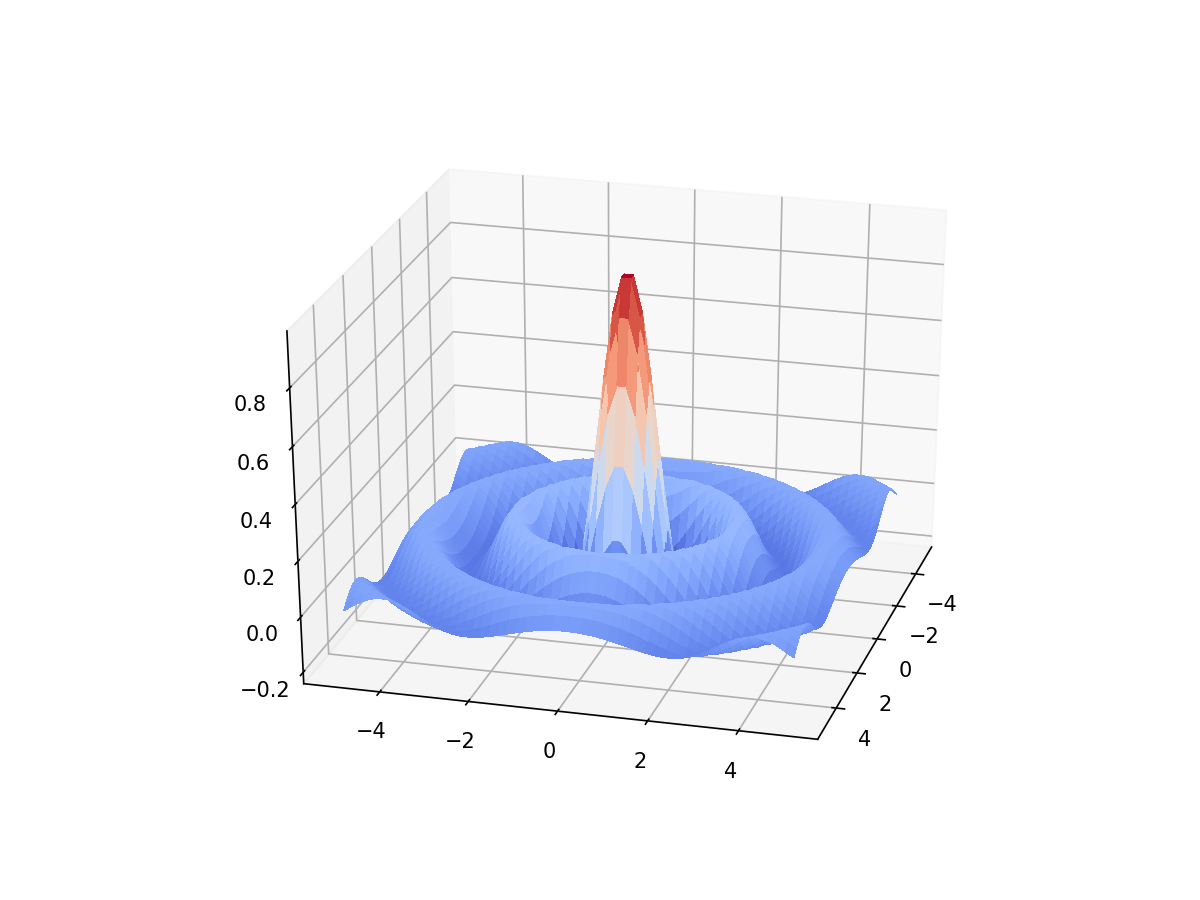

In [33]:
# plot the real function
%matplotlib notebook
Y = np.sinc(np.linalg.norm(Xtest, axis=1))
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xv, yv, Y.reshape(50,50), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

In [34]:
# RBF/Squared Expo. Kernel
def kernel(X, l=1, sig_var=1):
    if isinstance(X, list):
        distance = sklearn.metrics.pairwise_distances(*X)
    else:
        distance = sklearn.metrics.pairwise_distances(X)
    return sig_var*np.exp(-1/(2*l**2)*distance**2)

In [35]:
def GP3D(Xtrain, Ytrain, Xtest, l=1, sig_var=1, noise_var=1):
    K_ss = kernel(Xtest, l, sig_var)
    K = kernel(Xtrain, l, sig_var)
    L = np.linalg.cholesky(K + noise_var*np.eye(len(Ytrain)))
    K_s = kernel([Xtrain, Xtest], l, sig_var)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, Ytrain))
    mu = (K_s.T@alpha).squeeze()
    v = np.linalg.solve(L, K_s)
    cov =  K_ss - v.T@v
    stdv = np.sqrt(np.diag(cov)).squeeze()
    return mu, cov, stdv

In [40]:
mu, cov, stdv = GP3D(Xtrain, Ytrain, Xtest, 1, 1, 0)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


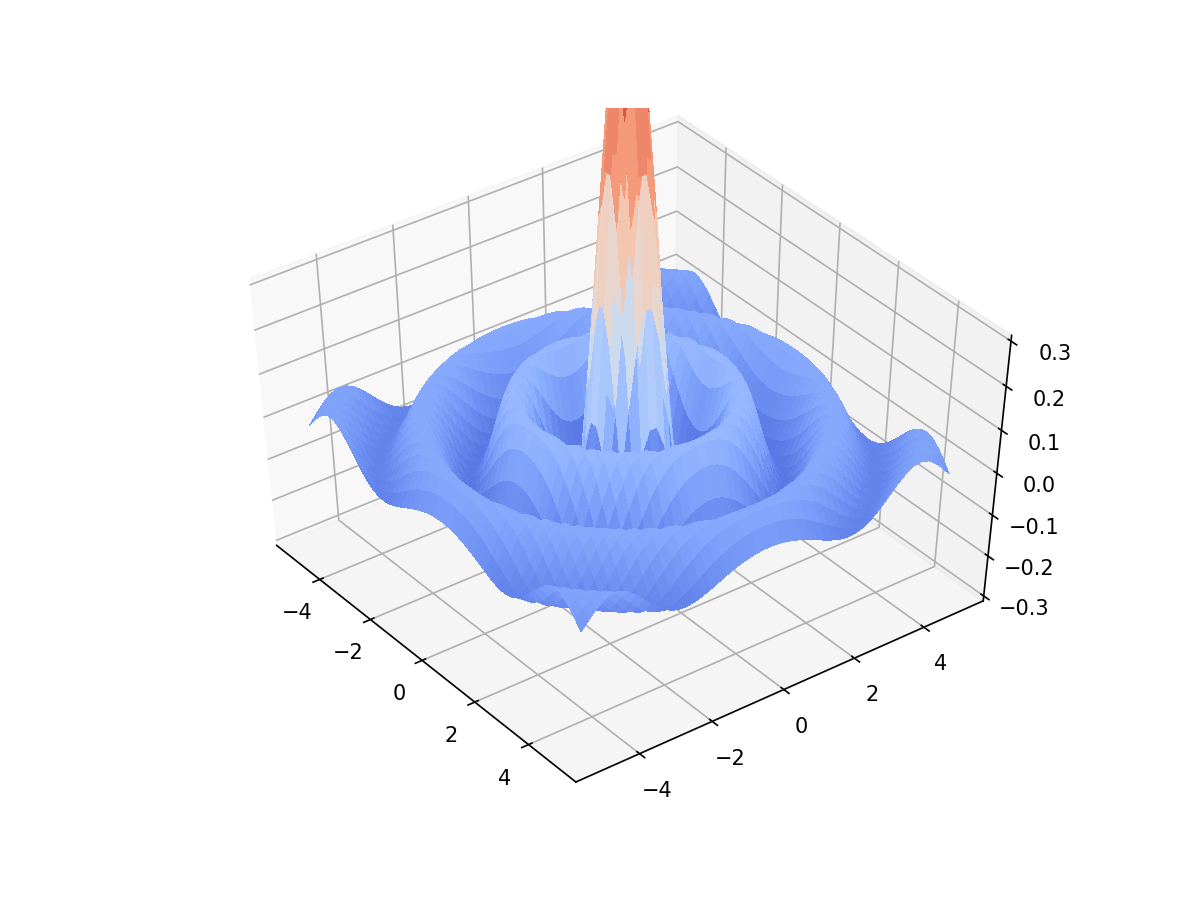

In [41]:
# %matplotlib notebook
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xv, yv, mu.reshape(50,50), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-0.3, 0.3)
plt.show()